In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
!pip install tensorflow-cpu

In [2]:
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import numpy as np
import opendatasets as od
import pandas as pd
import keras
from keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import InceptionResNetV2

/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
#od.download("https://www.kaggle.com/datasets/gonzajl/neumona-x-rays-dataset")

In [4]:
datos = pd.read_csv('data.csv')
cant_max = 1600

neumonia_df = datos[datos['neumonia'] == 1].head(cant_max)
no_neumonia_df = datos[datos['no_neumonia'] == 1].head(cant_max)

datos = pd.concat([neumonia_df, no_neumonia_df], ignore_index=True)

In [5]:
datos = datos.sample(frac=1).reset_index(drop=True)

In [6]:
imagenes = []
etiquetas = []
# Leer y procesar todas las imágenes
for i, fila in datos.iterrows():
    if fila['neumonia'] == 1 or fila['no_neumonia'] == 1:
        ruta_imagen = fila['imagen']
        # Leer la imagen desde la ruta
        imagen = cv2.imread(ruta_imagen, cv2.IMREAD_COLOR)
        imagen = cv2.resize(imagen, (224, 224))
        imagenes.append(imagen)
        if fila['neumonia'] == 1:
            etiquetas.append(1)
        elif fila['no_neumonia'] == 1:
            etiquetas.append(0)

In [7]:
div_test = int(len(imagenes) * 0.8)

imagenes_entrenamiento, imagenes_prueba = imagenes[:div_test], imagenes[div_test:]
etiquetas_entrenamiento, etiquetas_prueba = etiquetas[:div_test], etiquetas[div_test:]

# Convierte las listas a arreglos NumPy si no están en ese formato
imagenes_entrenamiento = np.array(imagenes_entrenamiento)
etiquetas_entrenamiento = np.array(etiquetas_entrenamiento)

# Asegurar que las etiquetas estén en el formato correcto si son una lista de listas
etiquetas_entrenamiento = np.array([np.array(etiqueta) for etiqueta in etiquetas_entrenamiento])

imagenes_entrenamiento = np.array(imagenes_entrenamiento).astype(float) / 255
imagenes_prueba = np.array(imagenes_prueba).astype(float) / 255

etiquetas_entrenamiento = np.array(etiquetas_entrenamiento)
etiquetas_prueba = np.array(etiquetas_prueba)

In [8]:
len(etiquetas_entrenamiento) + len(etiquetas_prueba)

3200

In [9]:
# Cargar el modelo InceptionResNetV2 preentrenado
base_model = InceptionResNetV2(
    include_top=False, weights="imagenet", input_shape=(224, 224, 3)
)

# Agregar una capa de agrupación global promedio
x = GlobalAveragePooling2D()(base_model.output)

# Agregar la nueva capa densa para la clasificación con 2 clases y activación sigmoid
predictions = Dense(1, activation="sigmoid")(x)

# Crear un nuevo modelo combinando el modelo base y las nuevas capas
InceptionResNet = Model(inputs=base_model.input, outputs=predictions)

InceptionResNet.compile(
    optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]
)

historial = InceptionResNet.fit(
    imagenes_entrenamiento,
    etiquetas_entrenamiento,
    epochs=10,
    validation_data=(imagenes_prueba, etiquetas_prueba)
)

Epoch 1/10
80/80 [==============================] - 469s 5s/step - loss: 0.1710 - accuracy: 0.9320 - val_loss: 0.4518 - val_accuracy: 0.9156
Epoch 2/10
80/80 [==============================] - 435s 5s/step - loss: 0.0727 - accuracy: 0.9734 - val_loss: 0.1817 - val_accuracy: 0.9406
Epoch 3/10
80/80 [==============================] - 434s 5s/step - loss: 0.0551 - accuracy: 0.9801 - val_loss: 0.2395 - val_accuracy: 0.9141
Epoch 4/10
80/80 [==============================] - 431s 5s/step - loss: 0.0282 - accuracy: 0.9895 - val_loss: 0.1527 - val_accuracy: 0.9531
Epoch 5/10
80/80 [==============================] - 428s 5s/step - loss: 0.0134 - accuracy: 0.9957 - val_loss: 0.2276 - val_accuracy: 0.9547
Epoch 6/10
80/80 [==============================] - 427s 5s/step - loss: 0.0377 - accuracy: 0.9867 - val_loss: 0.2592 - val_accuracy: 0.9359
Epoch 7/10
80/80 [==============================] - 426s 5s/step - loss: 0.0152 - accuracy: 0.9945 - val_loss: 0.1225 - val_accuracy: 0.9781
Epoch 8/10
80

In [10]:
def es_correcta(prediccion, esperado):
    return round(prediccion) == esperado

correctas_segun_tipo = [0, 0]
falladas_segun_tipo = [0, 0]

predicciones = InceptionResNet.predict(imagenes_prueba)
print(f"Cantidad de predicciones: {len(predicciones)}")

for i in range(len(predicciones)):
    prediccion = predicciones[i][0]  # Solo necesitas el valor de la clase "neumonía"
    etiqueta_real = etiquetas_prueba[i]

    if es_correcta(prediccion, etiqueta_real):
        if etiqueta_real == 1:
            correctas_segun_tipo[0] += 1  # Clase "neumonía"
        else:
            correctas_segun_tipo[1] += 1  # Clase "no_neumonía"
    else:
        if etiqueta_real == 1:
            falladas_segun_tipo[0] += 1
        else:
            falladas_segun_tipo[1] += 1

cant_totales = list(map(lambda x, y: x + y, correctas_segun_tipo, falladas_segun_tipo))
print("Etiquetas:       [Neumonía, No_Neumonía]")
print(f"Total:           {cant_totales}")
print(f"Correctas:       {correctas_segun_tipo}")
print(f"Incorrectas:     {falladas_segun_tipo}")


20/20 [==============================] - 25s 1s/step
Cantidad de predicciones: 640
Etiquetas:       [Neumonía, No_Neumonía]
Total:           [334, 306]
Correctas:       [329, 274]
Incorrectas:     [5, 32]


In [12]:
InceptionResNet.save("modelo_inc_res_net.h5")

/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [13]:
InceptionResNet.save('inceptionresnet_model.keras')

In [15]:
final_val_accuracy = historial.history['val_accuracy'][-1]
final_val_accuracy_percent = final_val_accuracy * 100
print(final_val_accuracy_percent)

94.2187488079071


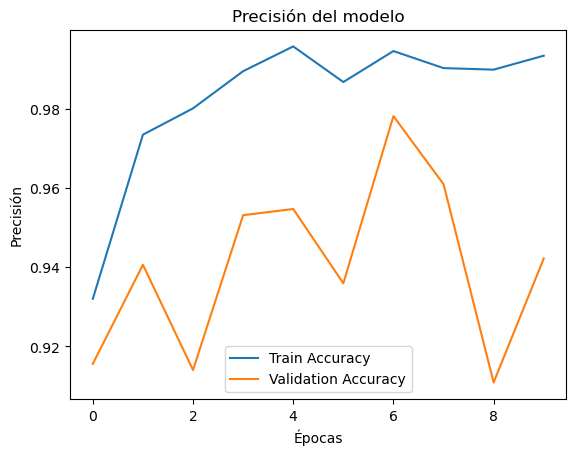

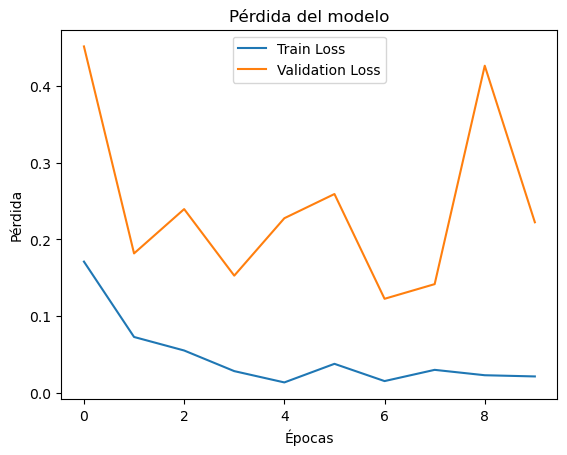

In [16]:
import matplotlib.pyplot as plt

# Historial del entrenamiento
history = historial.history

# Precisión en entrenamiento y validación
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

# Pérdida en entrenamiento y validación
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()


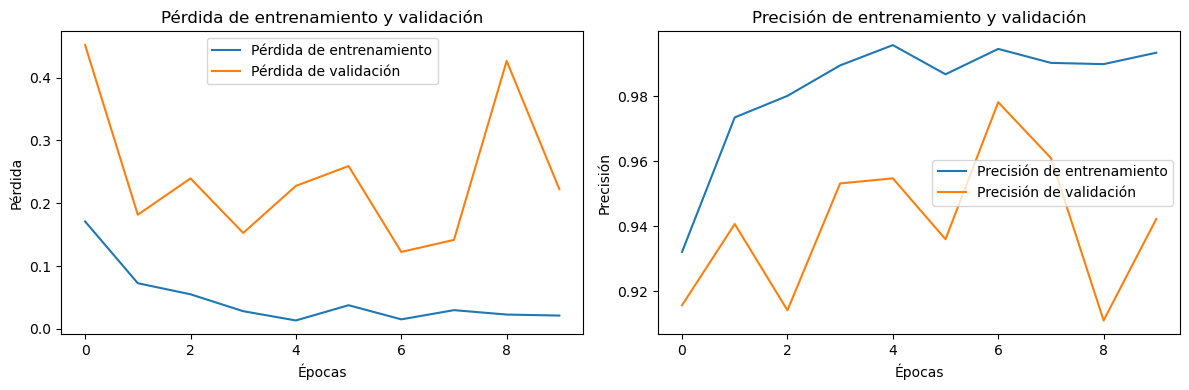

In [17]:
import matplotlib.pyplot as plt

# Obtener la pérdida y la precisión del entrenamiento y la validación del historial
loss = historial.history['loss']
val_loss = historial.history['val_loss']
accuracy = historial.history['accuracy']
val_accuracy = historial.history['val_accuracy']

# Crear gráficos para la pérdida
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(loss, label='Pérdida de entrenamiento')
plt.plot(val_loss, label='Pérdida de validación')
plt.legend()
plt.title('Pérdida de entrenamiento y validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')

# Crear gráficos para la precisión
plt.subplot(1, 2, 2)
plt.plot(accuracy, label='Precisión de entrenamiento')
plt.plot(val_accuracy, label='Precisión de validación')
plt.legend()
plt.title('Precisión de entrenamiento y validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')

plt.tight_layout()
plt.show()
